# Our Goal

Our model is designed to compute:

$x_{t+1}$ from $x_t$

So we can directly predict the next state of our system given the current state.

Unlike the base model, we will use a single set of fixed parameters for the entire dataset, rather than generating new parameters for each datapoint.

# Our Data

Our model receives:
- $x_t$: Current state

And attempts to predict:
- $x_{t+1}$: The next state

We generate our data by:
- First establishing fixed physical parameters for the entire dataset
- Then for each datapoint:
  - Generating a new, random initial state $x_t$
  - Running it forward one timestep to get $x_{t+1}$
  - Using this pair to create one datapoint
  - Repeat with new random initial states but same fixed parameters

# Imports

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np
from typing import Dict, Tuple, List
import helper
import matplotlib.pyplot as plt
import os
import h5py
from tqdm import tqdm

# Class for generating data

In [ ]:
class StateModelDataset(Dataset):
    def __init__(self, num_samples: int, nr: int, nc: int, dt: float, F: float):
        """
        Initialize dataset with fixed parameters for all samples.
        
        Args:
            num_samples (int): Number of samples to generate
            nr (int): Number of rows in grid
            nc (int): Number of columns in grid
            dt (float): Time step size
            F (float): Forcing parameter
        """
        self.num_samples = num_samples
        self.nr = nr
        self.nc = nc
        self.dt = dt
        self.F = F
        
        # Generate fixed parameters once (used internally but not stored in samples)
        self.fixed_params = self._generate_params()
        self.samples = self._generate_samples()

    def _generate_gaussian_field(self, n, nrv, ncv):
        """
        Generate a Gaussian field composed of n Gaussian functions.
        """
        mux = np.random.choice(ncv, n)
        muy = np.random.choice(range(2, nrv - 2), n)
        sigmax = np.random.uniform(1, ncv/4, n)
        sigmay = np.random.uniform(1, nrv/4, n)

        v = np.zeros((nrv, ncv))
        for i in range(n):
            for x in range(ncv):
                for y in range(nrv):
                    # Create three copies for pseudo-periodic field
                    gauss = np.exp(-((x-mux[i])**2/(2*sigmax[i]**2) + (y-muy[i])**2/(2*sigmay[i]**2)))
                    gauss += np.exp(-((x-(mux[i]-ncv))**2/(2*sigmax[i]**2) + (y-muy[i])**2/(2*sigmay[i]**2)))
                    gauss += np.exp(-((x-(mux[i]+ncv))**2/(2*sigmax[i]**2) + (y-muy[i])**2/(2*sigmay[i]**2)))
                    v[y,x] += gauss
        return v

    def _generate_circular_field(self, v):
        """
        Generate a circular field from gradient of input field.
        """
        grad_v_y, grad_v_x = np.gradient(v)
        return -grad_v_y, grad_v_x

    def _generate_params(self):
        """
        Generate fixed model parameters to be used for all samples.
        """
        # Base grid parameters
        DX_C = torch.ones(self.nr, self.nc + 1)
        DY_C = torch.ones(self.nr + 1, self.nc)
        DX_G = torch.ones(self.nr + 1, self.nc)
        DY_G = torch.ones(self.nr, self.nc + 1)
        RAC = torch.ones(self.nr, self.nc)

        # Generate random diffusivities (must be positive)
        KX = torch.abs(torch.rand(self.nr, self.nc + 1))
        KY = torch.abs(torch.rand(self.nr + 1, self.nc))

        # Generate velocities using Gaussian field approach
        num_gauss = 16  # Number of Gaussian functions for velocity field
        gauss = self._generate_gaussian_field(num_gauss, self.nr + 1, self.nc + 1)
        VX_np, VY_np = self._generate_circular_field(gauss)
        
        # Convert velocities to PyTorch and scale
        VX = torch.from_numpy(100 * VX_np[:-1, :]).float()
        VY = torch.from_numpy(100 * VY_np[:, :-1]).float()

        # Create random forcing term
        f = torch.randn(self.nr * self.nc)

        return {
            'KX': KX,
            'KY': KY,
            'DX_C': DX_C,
            'DY_C': DY_C,
            'DX_G': DX_G,
            'DY_G': DY_G,
            'VX': VX,
            'VY': VY,
            'RAC': RAC,
            'f': f,
        }

    def _compute_next_state(self, x_t):
        """
        Compute x(t+1) using fixed parameters.
        """
        # Convert PyTorch tensors to numpy arrays for helper function
        np_params = {
            key: tensor.cpu().detach().numpy() if torch.is_tensor(tensor) else tensor
            for key, tensor in self.fixed_params.items()
        }
        
        # Get model matrix M using helper function
        M = helper.make_M_2d_diffusion_advection_forcing(
            nr=self.nr,
            nc=self.nc,
            dt=self.dt,
            KX=np_params['KX'],
            KY=np_params['KY'],
            DX_C=np_params['DX_C'],
            DY_C=np_params['DY_C'], 
            DX_G=np_params['DX_G'],
            DY_G=np_params['DY_G'],
            VX=np_params['VX'],
            VY=np_params['VY'],
            RAC=np_params['RAC'],
            F=self.F,
            cyclic_east_west=True,
            cyclic_north_south=False,
            M_is_sparse=False
        )
        
        # Convert to numpy arrays and do matrix multiplication
        x_t_np = x_t.cpu().detach().numpy()
        f_np = np_params['f']
        
        # Compute next state: x(t+1) = Mx(t) + Ff
        result_np = M @ x_t_np + self.F * f_np
        
        # Convert back to PyTorch tensor
        return torch.from_numpy(result_np).float()

    def _generate_samples(self) -> list:
        """Generate multiple samples using fixed parameters but only store states."""
        samples = []
        for _ in range(self.num_samples):
            if _ % 10000 == 0:
                print(f"Generating sample {_+1}/{self.num_samples}")
            x_t = torch.randn(self.nr * self.nc)  # Random initial state
            x_t_plus_1 = self._compute_next_state(x_t)  # Next state
            samples.append((x_t, x_t_plus_1))  # Only store the states
        return samples

    def __len__(self) -> int:
        return self.num_samples

    def __getitem__(self, idx: int):
        return self.samples[idx]



# Class for Model

In [ ]:
class StateModelNet(torch.nn.Module):
    def __init__(self, nr: int, nc: int):
        super().__init__()
        self.nr = nr
        self.nc = nc
        
        self.state_size = nr * nc
        self.input_size = self.state_size  # Now only takes state as input
        self.output_size = self.state_size
        
        print(f"Input size: {self.input_size}")
        
        # Original simple architecture with two layers
        self.fc1 = torch.nn.Linear(self.input_size, 100)
        self.fc2 = torch.nn.Linear(100, self.output_size)
        self.activation = torch.nn.ReLU()
        
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        batch_size = x.size(0)
        
        # Ensure x has correct shape
        x = x.view(batch_size, -1)
        
        # Forward pass
        x = self.activation(self.fc1(x))
        x = self.fc2(x)
        
        return x




# Code to generate/load dataset

In [ ]:
def generate_and_save_dataset(
    filename: str,
    num_train_samples: int,
    num_test_samples: int,
    nr: int,
    nc: int,
    dt: float,
    F: float
) -> None:
    # Create dataset instances
    train_dataset = StateModelDataset(num_train_samples, nr, nc, dt, F)
    test_dataset = StateModelDataset(num_test_samples, nr, nc, dt, F)
    
    with h5py.File(filename, 'w') as f:
        # Create train and test groups
        train_group = f.create_group('train')
        test_group = f.create_group('test')
        
        # Save metadata
        f.attrs['nr'] = nr
        f.attrs['nc'] = nc
        f.attrs['dt'] = dt
        f.attrs['F'] = F
        
        # Helper function to save a single dataset
        def save_dataset(group, dataset, desc):
            # Save samples directly without params
            samples_group = group.create_group('samples')
            for i, (x_t, x_t_plus_1) in enumerate(tqdm(dataset, desc=desc)):
                sample_group = samples_group.create_group(f'sample_{i}')
                sample_group.create_dataset('x_t', data=x_t.numpy())
                sample_group.create_dataset('x_t_plus_1', data=x_t_plus_1.numpy())
        
        # Save training and testing datasets
        save_dataset(train_group, train_dataset, "Saving training data")
        save_dataset(test_group, test_dataset, "Saving testing data")

def load_dataset(filename: str) -> Tuple[Dict, Dict]:
    train_data = []
    test_data = []
    
    with h5py.File(filename, 'r') as f:
        metadata = {
            'nr': f.attrs['nr'],
            'nc': f.attrs['nc'],
            'dt': f.attrs['dt'],
            'F': f.attrs['F']
        }
        
        def load_dataset(group):
            data = []
            samples_group = group['samples']
            for sample_name in tqdm(samples_group.keys(), desc=f"Loading {group.name} data"):
                sample = samples_group[sample_name]
                
                # Load only states
                x_t = torch.from_numpy(sample['x_t'][:]).float()
                x_t_plus_1 = torch.from_numpy(sample['x_t_plus_1'][:]).float()
                
                # Add to data list without fixed parameters
                data.append((x_t, x_t_plus_1))
                
            return data
        
        train_data = load_dataset(f['train'])
        test_data = load_dataset(f['test'])
    
    return {
        'train': train_data,
        'metadata': metadata
    }, {
        'test': test_data,
        'metadata': metadata
    }

class SavedDataset(torch.utils.data.Dataset):
    """Dataset class for loading pre-saved data"""
    def __init__(self, data):
        self.data = data
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        return self.data[idx]
    
def create_dataloaders(train_data, test_data, batch_size=32, shuffle_train=True):
    """
    Create DataLoader objects for training and testing datasets.
    Now handles data without parameters.
    
    Args:
        train_data: Training dataset
        test_data: Testing dataset
        batch_size: Batch size for DataLoaders
        shuffle_train: Whether to shuffle training data
        
    Returns:
        train_loader, test_loader: DataLoader objects
    """
    train_dataset = SavedDataset(train_data['train'])
    test_dataset = SavedDataset(test_data['test'])
    
    train_loader = DataLoader(
        train_dataset, 
        batch_size=batch_size, 
        shuffle=shuffle_train,
        num_workers=0,  # Adjust based on system
        pin_memory=True  # Helps with GPU transfer
    )
    
    test_loader = DataLoader(
        test_dataset, 
        batch_size=batch_size, 
        shuffle=False,
        num_workers=0,  # Adjust based on system
        pin_memory=True  # Helps with GPU transfer
    )
    
    return train_loader, test_loader

In [ ]:
# Generate and save datasets
"""
generate_and_save_dataset(
    filename='state_model_data_one-world.h5',
    num_train_samples=180000,
    num_test_samples=20000,
    nr=10,
    nc=10,
    dt=0.1,
    F=1.0
)

# Load dataset and create dataloaders
train_data, test_data = load_dataset('state_model_data_one-world.h5')
train_loader, test_loader = create_dataloaders(
    train_data, 
    test_data, 
    batch_size=32
)
"""

"\ngenerate_and_save_dataset(\n    filename='state_model_data_one-world.h5',\n    num_train_samples=180000,\n    num_test_samples=20000,\n    nr=10,\n    nc=10,\n    dt=0.1,\n    F=1.0\n)\n\n# Load dataset and create dataloaders\ntrain_data, test_data = load_dataset('state_model_data_one-world.h5')\ntrain_loader, test_loader = create_dataloaders(\n    train_data, \n    test_data, \n    batch_size=32\n)\n"

# Training and Evaluating the Model

In [ ]:
def train_and_evaluate_model(
    model: torch.nn.Module,
    train_dataloader: DataLoader,
    test_dataloader: DataLoader,
    num_epochs: int,
    learning_rate: float,
    device: str = 'cpu',
    run_number: int = None
):
    model = model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    criterion = torch.nn.MSELoss()
    
    train_losses = []
    test_losses = []
    
    run_str = f" (Run {run_number})" if run_number is not None else ""
    print(f"Training started{run_str}...")
    
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        total_train_loss = 0
        for x_t, x_t_plus_1 in train_dataloader:  # Now unpacking only states
            x_t = x_t.to(device)
            x_t_plus_1 = x_t_plus_1.to(device)
            
            optimizer.zero_grad()
            predicted = model(x_t)
            loss = criterion(predicted, x_t_plus_1)
            loss.backward()
            optimizer.step()
            total_train_loss += loss.item()
        
        # Evaluation phase
        model.eval()
        total_test_loss = 0
        with torch.no_grad():
            for x_t, x_t_plus_1 in test_dataloader:
                x_t = x_t.to(device)
                x_t_plus_1 = x_t_plus_1.to(device)
                
                predicted = model(x_t)
                test_loss = criterion(predicted, x_t_plus_1)
                total_test_loss += test_loss.item()
        
        avg_train_loss = total_train_loss / len(train_dataloader)
        avg_test_loss = total_test_loss / len(test_dataloader)
        
        train_losses.append(avg_train_loss)
        test_losses.append(avg_test_loss)
        
        if (epoch + 1) % 10 == 0:
            print(f"Epoch {epoch+1}/{num_epochs}")
            print(f"Training Loss: {avg_train_loss:.6f}")
            print(f"Test Loss: {avg_test_loss:.6f}")
    
    print(f"Training complete{run_str}!")
    return model, train_losses, test_losses

def train_multiple_models(
    nr: int, 
    nc: int, 
    train_dataloader: DataLoader,
    test_dataloader: DataLoader,
    num_runs: int = 10,
    num_epochs: int = 50,
    learning_rate: float = 0.001,
    device: str = 'cpu'
):
    all_models = []
    all_train_losses = []
    all_test_losses = []
    
    for i in range(num_runs):
        print(f"\nStarting model {i+1}/{num_runs}")
        model = StateModelNet(nr, nc)
        
        trained_model, train_losses, test_losses = train_and_evaluate_model(
            model=model,
            train_dataloader=train_dataloader,
            test_dataloader=test_dataloader,
            num_epochs=num_epochs,
            learning_rate=learning_rate,
            device=device,
            run_number=i+1
        )
        
        # Plot individual run results
        plt.figure(figsize=(10, 6))
        epochs = range(1, num_epochs + 1)
        plt.plot(epochs, train_losses, 'b-', label='Training Loss')
        plt.plot(epochs, test_losses, 'r-', label='Test Loss')
        plt.title(f'Training and Testing Loss Over Time - Run {i+1}')
        plt.xlabel('Epoch')
        plt.ylabel('Loss (MSE)')
        plt.legend()
        plt.grid(True)
        plt.show()
        
        all_models.append(trained_model)
        all_train_losses.append(train_losses)
        all_test_losses.append(test_losses)
    
    return all_models, all_train_losses, all_test_losses

Loading /test data: 100%|██████████| 20000/20000 [00:24<00:00, 819.09it/s]



Starting model 1/10
Input size: 100
Training started (Run 1)...
Epoch 10/50
Training Loss: 111.198215
Test Loss: 101.391121
Epoch 20/50
Training Loss: 38.165584
Test Loss: 93.817074
Epoch 30/50
Training Loss: 22.737132
Test Loss: 108.167538
Epoch 40/50
Training Loss: 19.334453
Test Loss: 112.312603
Epoch 50/50
Training Loss: 17.411381
Test Loss: 112.277248
Training complete (Run 1)!


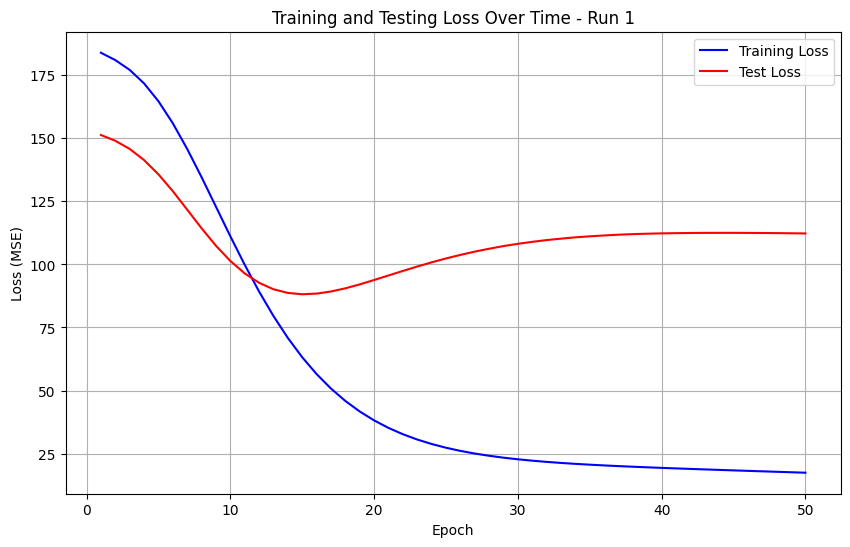


Starting model 2/10
Input size: 100
Training started (Run 2)...
Epoch 10/50
Training Loss: 111.116884
Test Loss: 101.900787
Epoch 20/50
Training Loss: 38.920060
Test Loss: 94.171295
Epoch 30/50
Training Loss: 22.965650
Test Loss: 107.738811
Epoch 40/50
Training Loss: 19.449008
Test Loss: 112.077374
Epoch 50/50
Training Loss: 17.463316
Test Loss: 112.108601
Training complete (Run 2)!


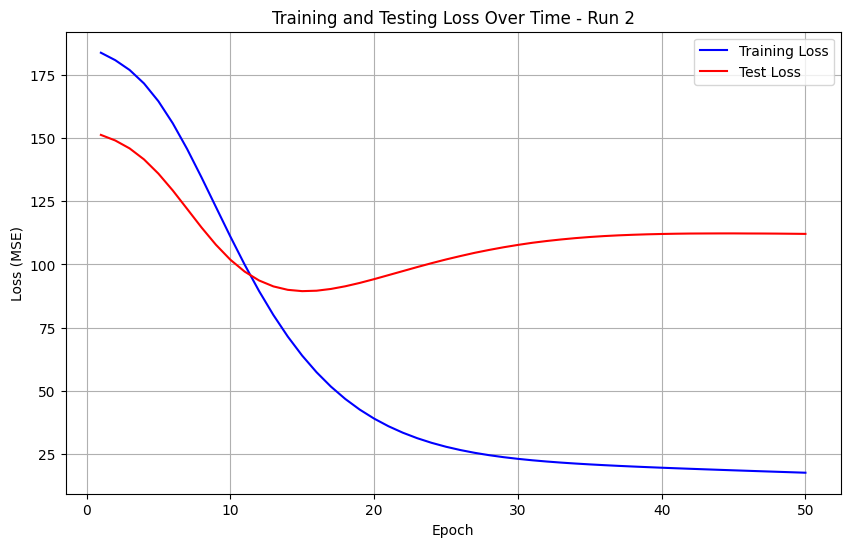


Starting model 3/10
Input size: 100
Training started (Run 3)...
Epoch 10/50
Training Loss: 110.762086
Test Loss: 101.236954
Epoch 20/50
Training Loss: 38.588497
Test Loss: 93.461720
Epoch 30/50
Training Loss: 22.940874
Test Loss: 107.599884
Epoch 40/50
Training Loss: 19.383330
Test Loss: 111.912552
Epoch 50/50
Training Loss: 17.348828
Test Loss: 111.943890
Training complete (Run 3)!


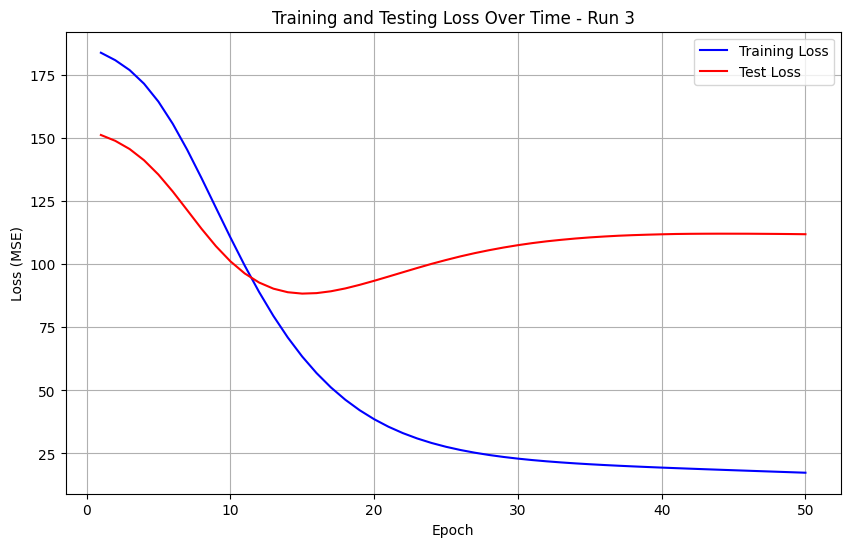


Starting model 4/10
Input size: 100
Training started (Run 4)...
Epoch 10/50
Training Loss: 110.979757
Test Loss: 100.958939
Epoch 20/50
Training Loss: 37.900383
Test Loss: 93.372913
Epoch 30/50
Training Loss: 22.675234
Test Loss: 107.887985
Epoch 40/50
Training Loss: 19.323301
Test Loss: 112.107723
Epoch 50/50
Training Loss: 17.374048
Test Loss: 112.109650
Training complete (Run 4)!


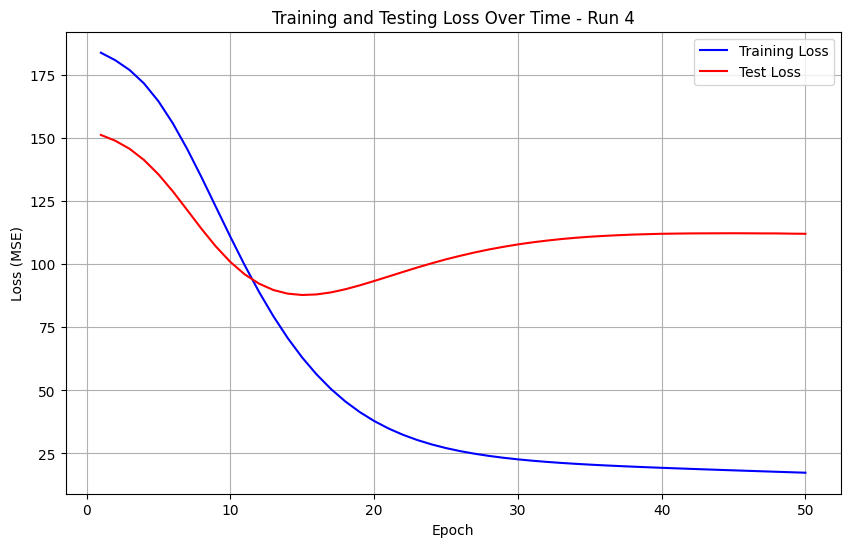


Starting model 5/10
Input size: 100
Training started (Run 5)...
Epoch 10/50
Training Loss: 111.232448
Test Loss: 101.896786
Epoch 20/50
Training Loss: 38.404888
Test Loss: 94.045147
Epoch 30/50
Training Loss: 22.898365
Test Loss: 108.223846
Epoch 40/50
Training Loss: 19.513678
Test Loss: 112.224270
Epoch 50/50
Training Loss: 17.601512
Test Loss: 112.183945
Training complete (Run 5)!


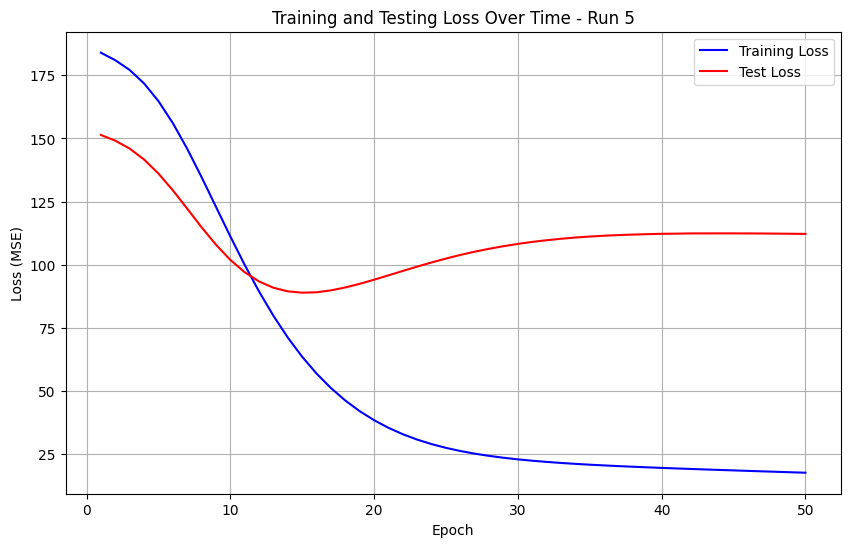


Starting model 6/10
Input size: 100
Training started (Run 6)...
Epoch 10/50
Training Loss: 111.560271
Test Loss: 101.290138
Epoch 20/50
Training Loss: 38.133601
Test Loss: 93.564991
Epoch 30/50
Training Loss: 22.581839
Test Loss: 108.429493
Epoch 40/50
Training Loss: 19.413472
Test Loss: 112.479134
Epoch 50/50
Training Loss: 17.467176
Test Loss: 112.265022
Training complete (Run 6)!


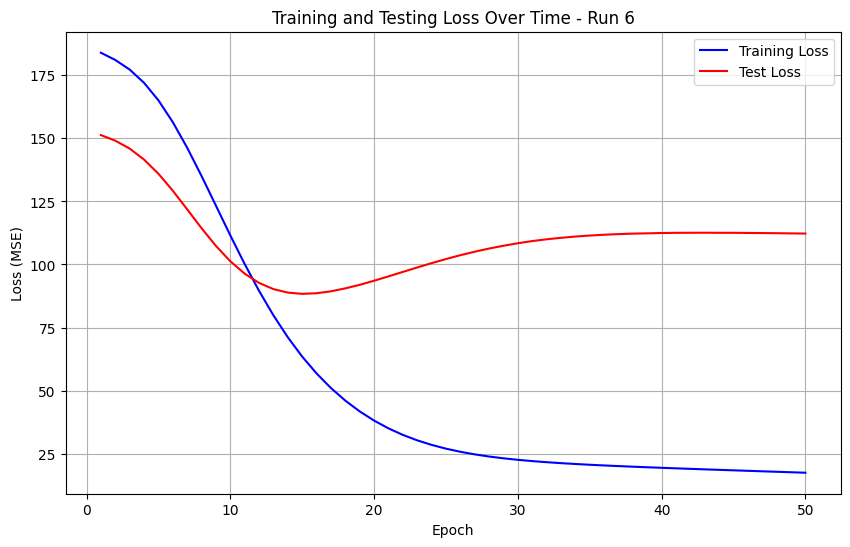


Starting model 7/10
Input size: 100
Training started (Run 7)...
Epoch 10/50
Training Loss: 110.601202
Test Loss: 101.440868
Epoch 20/50
Training Loss: 38.353175
Test Loss: 93.565773
Epoch 30/50
Training Loss: 22.860739
Test Loss: 107.986221
Epoch 40/50
Training Loss: 19.487247
Test Loss: 112.163658
Epoch 50/50
Training Loss: 17.543650
Test Loss: 112.253033
Training complete (Run 7)!


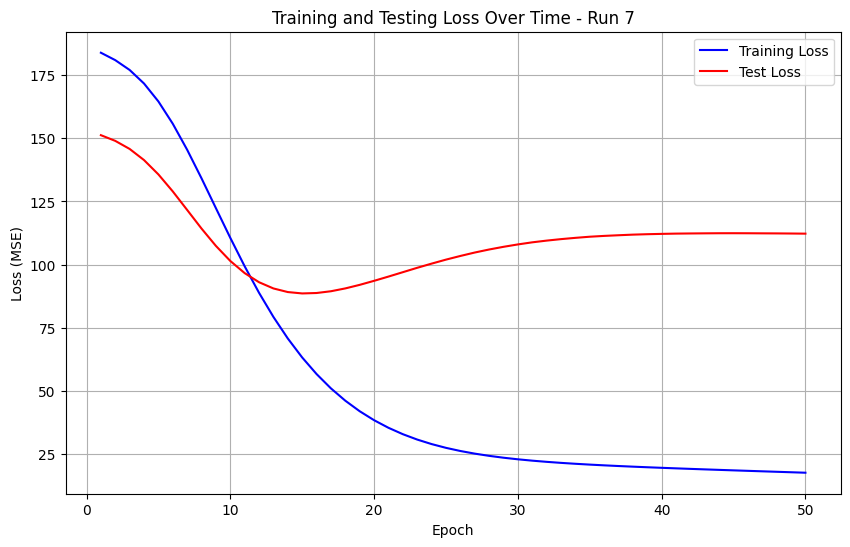


Starting model 8/10
Input size: 100
Training started (Run 8)...
Epoch 10/50
Training Loss: 110.894636
Test Loss: 101.275261
Epoch 20/50
Training Loss: 37.980910
Test Loss: 93.707340
Epoch 30/50
Training Loss: 22.578457
Test Loss: 108.053040
Epoch 40/50
Training Loss: 19.254776
Test Loss: 112.118870
Epoch 50/50
Training Loss: 17.336640
Test Loss: 112.124535
Training complete (Run 8)!


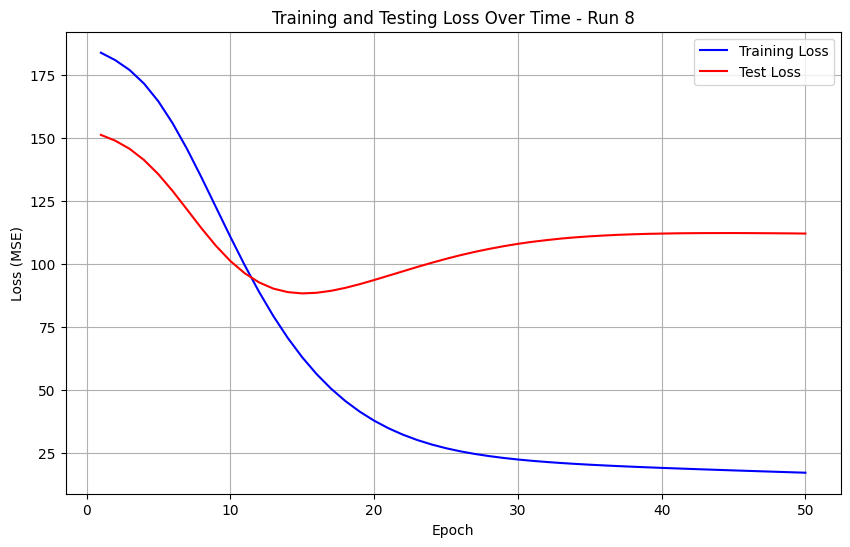


Starting model 9/10
Input size: 100
Training started (Run 9)...
Epoch 10/50
Training Loss: 111.457210
Test Loss: 101.462421
Epoch 20/50
Training Loss: 38.631460
Test Loss: 93.557102
Epoch 30/50
Training Loss: 22.779944
Test Loss: 107.973080
Epoch 40/50
Training Loss: 19.375545
Test Loss: 112.404770
Epoch 50/50
Training Loss: 17.462467
Test Loss: 112.419945
Training complete (Run 9)!


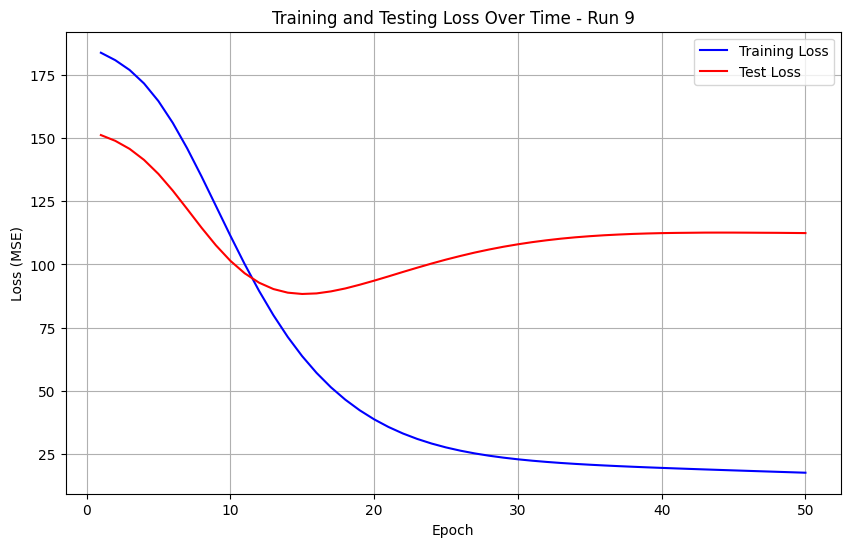


Starting model 10/10
Input size: 100
Training started (Run 10)...
Epoch 10/50
Training Loss: 111.077018
Test Loss: 101.356812
Epoch 20/50
Training Loss: 38.871504
Test Loss: 94.035858
Epoch 30/50
Training Loss: 22.809540
Test Loss: 107.933704
Epoch 40/50
Training Loss: 19.261881
Test Loss: 112.259598
Epoch 50/50
Training Loss: 17.224912
Test Loss: 112.260349
Training complete (Run 10)!


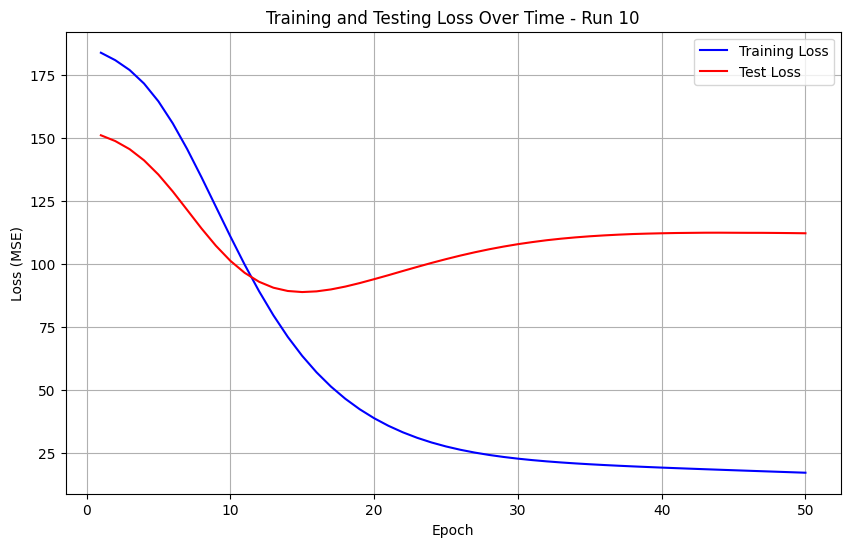

In [ ]:
train_data, test_data = load_dataset('state_model_data_one-world.h5')
train_loader = DataLoader(SavedDataset(train_data['train']), batch_size=10000, shuffle=True)
test_loader = DataLoader(SavedDataset(test_data['test']), batch_size=10000, shuffle=False)

# Train multiple models
device = 'cuda' if torch.cuda.is_available() else 'cpu'
models, train_losses, test_losses = train_multiple_models(
    nr=10, 
    nc=10, 
    train_dataloader=train_loader,
    test_dataloader=test_loader,
    num_runs=10,
    num_epochs=50,
    device=device)

- Simulate Using Model
- Include current parameters: describe how they work, how many weights we have vs parameters
- Try 100 hidden units
- Try linear model vs ReLU model
- Regularization